# Testing out MCMC in `pymc3` 

While we'd like to find optimal mass balance parameters using an Markov Chain Monte Carlo approach for our "spin-up" simulations, we first need to confirm the MCMC method
works as proposed. Here we define an MCMC model and test it on synthetic data. 



Let's define a simple toy model, analogous to our degree day model, to test our understanding of how MCMC is implemented in `pymc3`. For this we will just use a degree day melt model:
\begin{equation}
    M_{\rm melt}(z) = \sum^{365}_{d=1} \max\left[ \left( T(d,z) - T_{\rm melt} \right) f_{\rm m}(x), 0\right] ,
\end{equation}
forced by air temperature
\begin{equation}
    T(d,z) = \alpha \cos\left( \frac{2 \pi \left(d - \hat{T} \right) }{365} \right) + T_{\rm ma} + (z - z_{\rm ref}) \frac{d T}{dz} ,
\end{equation} 
where: 
- $\alpha$ is the annual air temperature amplitude (K), 
- $T_{\rm ma}$ is the mean annual air temperature at reference elevation $z_{\rm ref}$ (K) ,
- $\frac{d T}{dz}$ is the atmospheric lapse rate (K m$^{-1}$).
- $\hat{T}$ is the DOY of air temperature peak (d)
- $T_{\rm melt}$ is the temperature threshold for melting (K)
- $f_{\rm m}(x)$ is the nodally specific degree day factor described below ( kg m$^{-2}$  a$^{-1}$ K$^{-1}$) 


Let's set up our toy example with an surface elevation ($z$) of: 
\begin{equation}\label{eq:}
    z(x) = (0.05) \; x + 1000\;\;\;\;\ x \in [0, L] \; (\rm{m})
\end{equation}
where $L$ = 1 km. 

Let's now set some of our known parameters: 
  - $z_{\rm ref} = 1000$ [m a.s.l.]
  - $\alpha = 10.0$      [C]
  - $T_{\rm ma} = -2$    [C]
  - $\frac{d T}{dz} = 6.5\times10^{-3}$ [K m$^{-1}$]
  - $\hat{T} = 183$ [DOY]
  - $T_{\rm melt}$=0 [C]
  
which leaves $f_{\rm m}$ as the only free parameter. 

See Doug's first MCMC paper for more info: 
https://www-cambridge-org.proxy.lib.sfu.ca/core/services/aop-cambridge-core/content/view/B0468287399CE6B538FA834AB3B77341/S0260305516000033a.pdf/inversion-of-a-glacier-hydrology-model.pdf


https://www.boelstad.net/post/bayesian_statistics_introduction/


https://stackoverflow.com/questions/30426216/using-theano-shared-variables-with-pymc3

---- 

### `theano`/`pymc3` Details

We need to wrap the "melt model" so that it can be called by `pymc3` (and therefore `theano` under the hood). To this wrapping we have two options:   
1. Build `theano` "compiled" function to use as our deterministic problem. Top choice, but currently having a problem with passing "shared varibales. [See here](https://github.com/pymc-devs/pymc/issues/2176#issuecomment-304446692)  
  - https://stackoverflow.com/questions/39297736/pymc3-theano-function-usage  
  
  
2. Write our own `Op` which wraps out function call. Simple enough, but to use gradient based sampling methods we need implement a `grad` method, which is non trivial for now. For more info see [here](https://mattpitkin.github.io/samplers-demo/pages/pymc3-blackbox-likelihood/)
  - https://github.com/pymc-devs/pymc/issues/1925
  - https://github.com/alan-turing-institute/pymc3/blob/mlda_all_notebooks/docs/source/notebooks/MLDA_variance_reduction_groundwater.ipynb
  - https://theano-pymc.readthedocs.io/en/latest/extending/extending_theano.html#op-s-basic-methods


__Possible Extensions__:  
  - Instead of tunning in the $M\times 1$ mass balance vector, where $M$ is the number of surface nodes, we could think about tunning a $M\times 4$ matrix where the 4 columns are melt $M$, refreezing $R$, accumulation $M$, and mass balance $MB$ respectively.   
   - This doesn't make sense because we don't have the four vectors from the `Elmer\Ice` spinups.
   
   
__Notes__: 
- Model slope break has to do with number of "accumulation days". 

In [2]:
import theano
from theano import pp
import theano.tensor as tt
from dataclasses import dataclass

import time 
import pymc3 as pm 
import numpy as np
import arviz as az
import scipy.stats as st
import matplotlib.pyplot as plt 

In [35]:
# T   = tt.dmatrix('T')
# T_m = tt.dscalar('T_m')
# P0  = theano.shared(0.0)
# PDDs_func = theano.function([T, T_m], 
#                             tt.switch(tt.gt(T, T_m), T, P0).sum(axis=0) )
    

def air_temp(z): 
    doy = np.arange(1,366)[:, np.newaxis]

    α     = 10.0   # [C]
    T_ma  = -2.0   # [C]
    ΔTΔz  = 6.5E-3 # [K m^-1]
    T_p   = 183    # [doy]
    ref_z = 1000   # [m]

    return α*np.cos( 2*np.pi*(doy-T_p)/365 )+ΔTΔz*(ref_z-z)+T_ma
    
def tt_melt_model(z, f_snow, C, grad_A, f_r): 
    T_m    = 0.0
    T_rs   = 1.0
    A_mean = 2.4 * 910. 
    ref_z  = 1000
    
    f_ice = C*f_snow
    T     = air_temp(z) #+ T_bias
    
    PDDs = tt.switch(tt.gt(T, T_m), T, 0.0).sum(axis=0) 

    accum_days = tt.switch(tt.lt(T, T_rs), 1/365., 0.0).sum(axis=0)  

    # calculate snow accumulation
    A_snow = tt.maximum((accum_days*A_mean)*
                      (1+(z-ref_z)*grad_A), 0.0)
    
    # calculate local surface melt assuming f_m = f_snow
    melt_local = PDDs * f_snow
    
    # calculate refreezing
    R = tt.minimum(f_r*A_snow, melt_local)
    
    
    r_s2m = tt.switch(tt.eq(melt_local, 0.0), 1.0, A_snow/melt_local)
    
    f_m = tt.switch(tt.ge(r_s2m, 1.), f_snow,
                    f_ice - (f_ice - f_snow)*r_s2m)
    
    # calculate surface melt [kg m^{-2} yr^{-1}] with f_m
    M_melt = f_m*PDDs
    
    return (A_snow + R - M_melt) * (1/910)


def np_melt_model(z, f_snow, C, grad_A, f_r): 
    T_m    = 0.0
    T_rs   = 1.0
    A_mean = 2.4 * 910. 
    ref_z  = 1000
    
    f_ice = C*f_snow
    T     = air_temp(z) #+ T_bias
    
    PDDs = np.where(T>T_m,  T-T_m, 0).sum(axis=0)
    accum_days = np.where(T<T_rs, 1/365., 0.0).sum(axis=0)  

    # calculate snow accumulation
    A_snow = np.maximum((accum_days*A_mean)*
                      (1+(z-ref_z)*grad_A), 0.0)    
    
    # calculate local surface melt assuming f_m = f_snow
    melt_local = PDDs * f_snow
    
    # calculate refreezing
    R = np.minimum(f_r*A_snow, melt_local)
    
    # compute the ratio b/w accumulated snow and total melt assuming f_m = f_snow
    with np.errstate(divide='ignore', invalid='ignore'):
        r_s2m = np.where(melt_local==0.0, 1.0, A_snow / melt_local)
    
    # Compute nodal specific degree day factor
    f_m = np.where(r_s2m >= 1, f_snow,
                   f_ice - (f_ice - f_snow)*r_s2m)
        
    # calculate surface melt [kg m^{-2} yr^{-1}] with f_m
    M_melt = f_m*PDDs
    
    return (A_snow + R - M_melt) * (1/910)

In [4]:
L = 1e3                                 # Domain length      [m]
x = np.linspace(0, L, 100)              # x-vector           [m]
# Roughly following synthetic geom. from Brinkerhoff et al. 20..
z = (2e3-1e3)/L * x[np.newaxis,:] + \
    100*np.sin(2*np.pi*x / L) + \
    700*np.exp(-(x+L)/7e3) + 400        # surface elev. vec. [m a.s.l.]

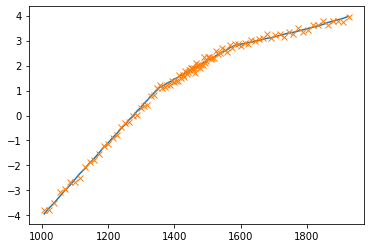

In [5]:
f_s_true  = 4.1 
C_true    = 2.1
f_r_true  = 0.5
ΔAΔz_true = 0.001

# 
melt     = np_melt_model(z, f_s_true, C_true, ΔAΔz_true, f_r_true)
# Add a small amount of random noise
melt_obs = np.random.normal(melt, 1e-1)

plt.plot(z[0], melt[0])
plt.plot(z[0], melt_obs[0], 'x')

In [6]:
# Define Priors
with pm.Model() as model: 
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----> Mass balance Model (physical priors)
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Degree Day factor: Braithwaite (2008) / Rounce et al. 2020
    f_s_prior  = pm.TruncatedNormal("f_s",    mu=4.1,  sigma=1.5,  lower=0)
    C_prior    = pm.TruncatedNormal("C",      mu=1.5,  sigma=1.5,  lower=1)
    grad_a     = pm.TruncatedNormal("grad_a", mu=1e-3, sigma=1e-2, lower=0)
    f_r_prior  = pm.TruncatedNormal('f_r',    mu=0.5,  sigma=0.5,  lower=0, upper=1)
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----> Hyperparameters (likelihood related priors)
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    sigma      = pm.HalfCauchy("sigma", 10)    


# Define Forward model (wrapped through theano)
with model: 
    melt, _ = theano.scan(fn=tt_melt_model, 
                sequences = [z],
                outputs_info = None, 
                non_sequences= [f_s_prior, C_prior, grad_a, f_r_prior])
    

# Define likelihood (function?)  
with model: 
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=melt, sigma=sigma, observed=melt_obs)
    
# run inference: Sample   
with model: 

    # obtain starting values via MAP
    startvals = pm.find_MAP()
    
    trace = pm.sample(start=startvals,
                      draws=2000, 
                      tune=1000, 
                      cores=1, 
                      return_inferencedata=True,
                      target_accept=0.8);

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, f_r, grad_a, C, f_s]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 46 seconds.


In [12]:
f_s_prior

f_s ~ TruncatedNormal

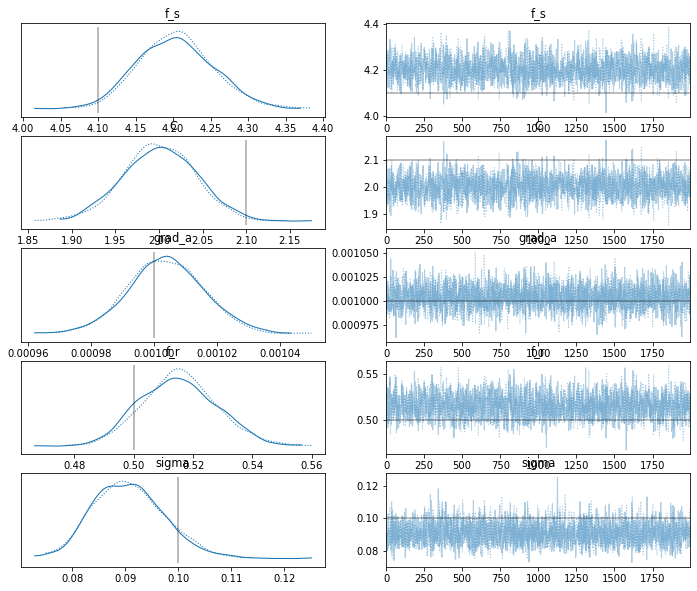

In [13]:
az.plot_trace(trace,  lines=[("f_s", {}, f_s_true), 
                             ("C", {}, C_true),
                             ("grad_a", {}, ΔAΔz_true),
                             ("f_r", {}, f_r_true),
                             ("sigma", {}, 1e-1) ], );

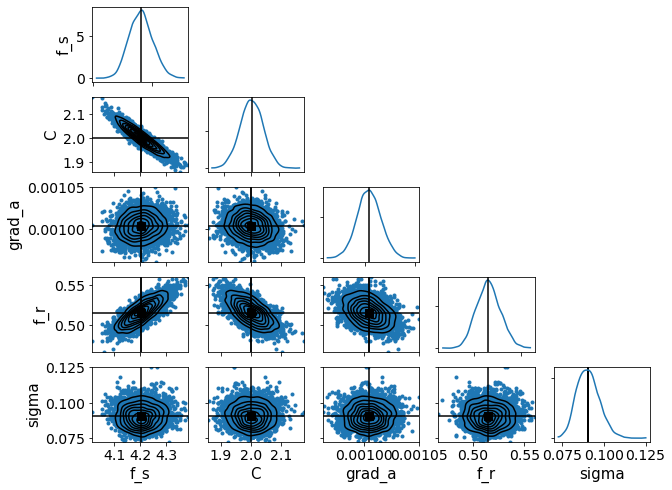

In [8]:
ax = az.plot_pair(
    trace,
    kind=["scatter", "kde"],
    kde_kwargs={"fill_last": False},
    marginals=True,
    point_estimate="median",
    figsize=(10, 8),
)


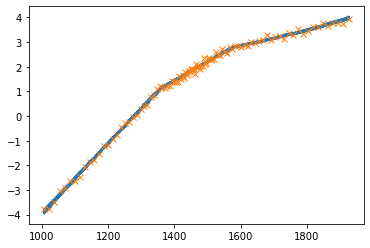

In [9]:
for i, j in zip(np.random.randint(0,2,499),
                np.random.randint(0,499,499)):
    data_vars = trace.posterior.isel(chain=i, draw=j).data_vars

    plt.plot(z[0], 
             np_melt_model(z, *[data_vars[key].values for key in data_vars][:-1])[0],
             c='tab:blue', 
             alpha=0.1)

plt.plot(z[0], melt_obs[0], 'x', c='tab:orange')


In [10]:
with model: 
    ppc = pm.sample_posterior_predictive(
    trace, var_names=["f_s", "C", "grad_a", "f_r", "sigma", "Y_obs"])

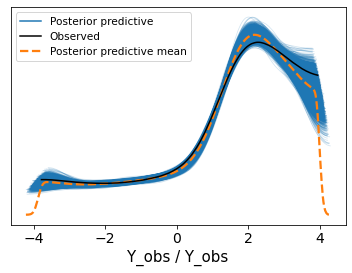

In [11]:
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=model));